**<div class="alert alert-block alert-warning"> Insomnia Classification</div>**

### Data

In [27]:
# import libraries

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split

In [51]:
# download datasets from local files

train = pd.read_csv('C:/Users/Mamadou Pene/Documents/TRAIN.csv')
test = pd.read_csv('C:/Users/Mamadou Pene/Documents/TEST.csv')
sample_submission = pd.read_csv('C:/Users/Mamadou Pene/Documents/idao-2022-bootcamp-insomnia/sample_submission.csv')

In [29]:
print('train, test, sample_submission shapes')
print(train.shape, test.shape, sample_submission.shape)
train.head(7)

train, test, sample_submission shapes
(70000, 13) (30000, 12) (30000, 2)


,id,age,weight,height,sex,stress,doctor,sport,pernicious_1,pernicious_2,ubp,lbp,insomnia
0,0,50.357290,62.0,168,2,1,1,1,0,0,110,80,0
1,1,55.381246,85.0,156,1,3,1,1,0,0,140,90,1
2,2,51.627652,64.0,165,1,3,1,0,0,0,130,70,1
3,3,48.249144,82.0,169,2,1,1,1,0,0,150,100,1
4,4,47.841205,56.0,156,1,1,1,0,0,0,100,60,0
5,8,59.997262,67.0,151,1,2,2,0,0,0,120,80,0
6,9,60.542094,93.0,157,1,3,1,1,0,0,130,80,0


In [30]:
print(train.sex.nunique())
print(train.stress.nunique())
print(train.doctor.nunique())
print(train.sport.nunique())
print(train.pernicious_1.nunique())
print(train.pernicious_2.nunique())

2
3
3
2
2
2


In [31]:
train.shape[0]

70000

### Feature overview 

In [32]:
feat_research = pd.DataFrame(train.isna().sum() / train.shape[0], columns=['train_null_share'])
feat_research['test_null_share'] = test.isna().sum() / test.shape[0]
feat_research['train_dtypes'] = train.dtypes
feat_research['train_mean'] = train.mean()
feat_research['test_mean'] = test.mean()

feat_research

,train_null_share,test_null_share,train_dtypes,train_mean,test_mean
id,0.0,0.000000,int64,49972.419900,50062.686900
age,0.0,0.000000,float64,53.302850,53.266334
weight,0.0,0.000000,float64,74.205690,74.120615
height,0.0,0.000000,int64,164.359229,164.322267
sex,0.0,0.000000,int64,1.349571,1.353733
stress,0.0,0.000000,int64,1.366871,1.368033
doctor,0.0,0.000000,int64,1.226457,1.222700
sport,0.0,0.096567,int64,0.803729,0.805926
pernicious_1,0.0,0.101000,int64,0.088129,0.087838
pernicious_2,0.0,0.101033,int64,0.053771,0.054470


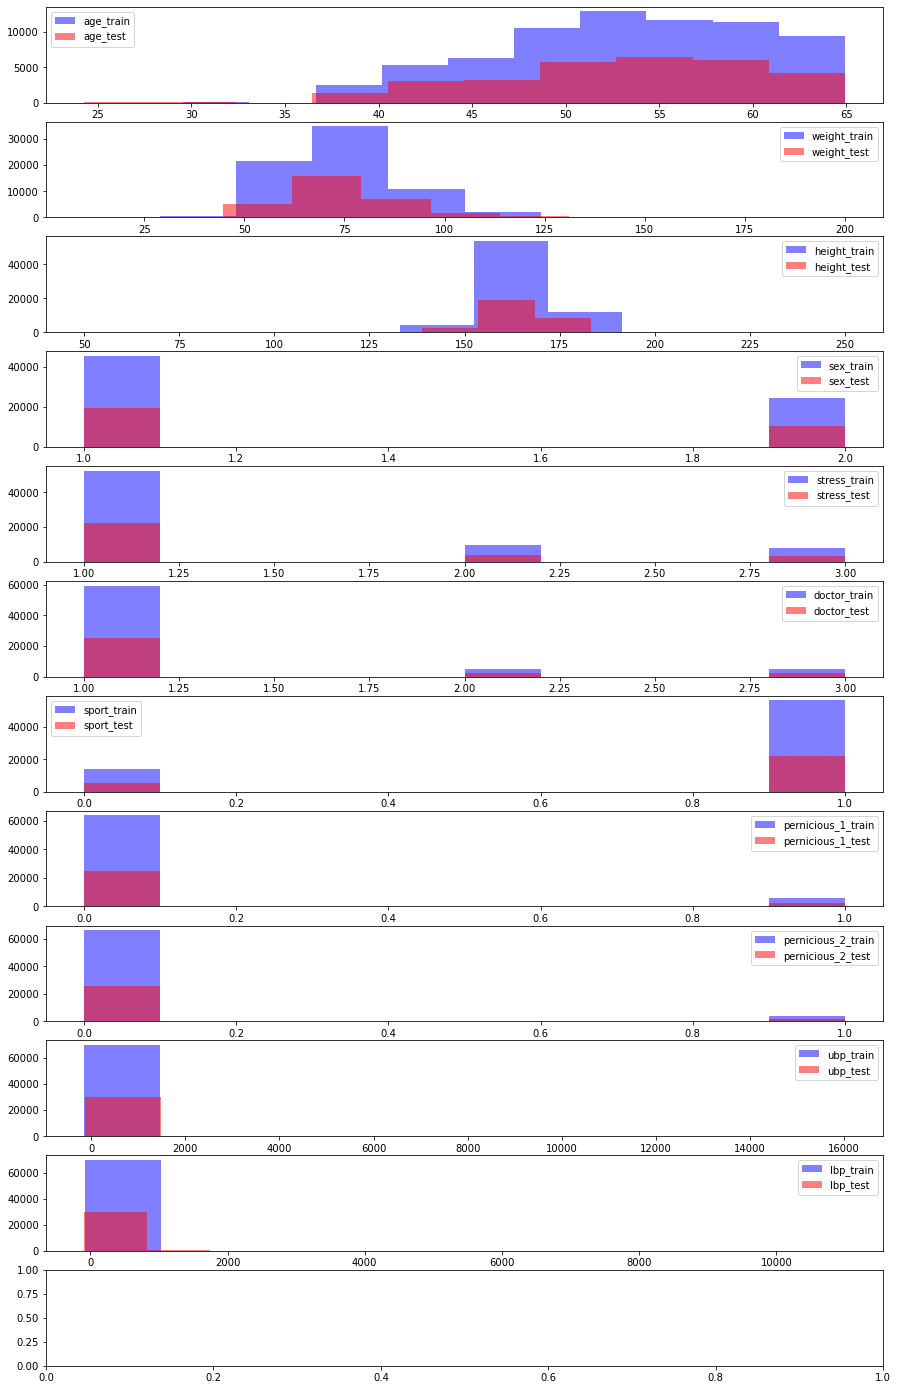

In [33]:
# data distribution 

fig, ax = plt.subplots(len(train.columns)-1, 1)
fig.set_figheight(25)
fig.set_figwidth(15)


for i in range(1, len(test.columns)):
    feat = train.columns[i]
    ax[i-1].hist(train[feat], label=feat+'_train', alpha=0.5, color='blue')
    ax[i-1].hist(test[feat], label=feat+'_test', alpha=0.5, color='red')
    ax[i-1].legend()

plt.show()

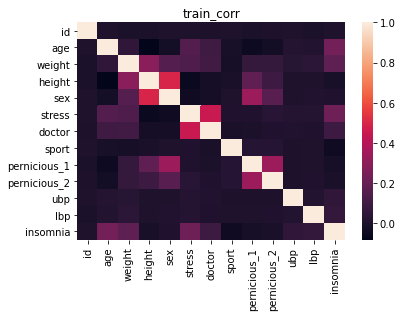

In [34]:
# train correlation matrix 

sns.heatmap(train.corr())
plt.title('train_corr')
plt.show()

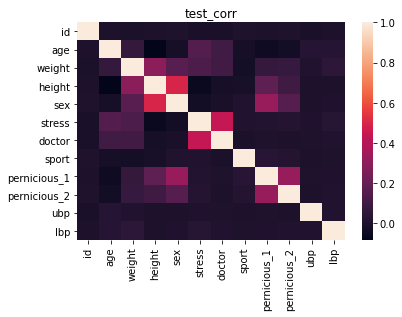

In [35]:
# test correlation matrix 

sns.heatmap(test.corr())
plt.title('test_corr')
plt.show()

### Feature processing

In [36]:
# drop *doctor* (correlated with *stress*, but less corrlatd with target) 
train = train.drop(columns=['doctor', 'id'])
test = test.drop(columns=['doctor', 'id'])

In [37]:
# fix nulls 

# pernicious_1 & pernicious_2 correelate with *sex* a little 
# so fill nulls with regard to it: 
# 1 for *sex* == 2 and 0, otherwise 
pernicious_1_nan_male = np.where((np.isnan(test['pernicious_1']) & (test['sex']==2)), 
                               1, 
                               test['pernicious_1'])
test['pernicious_1'] = pernicious_1_nan_male
test['pernicious_1'] = test['pernicious_1'].fillna(0)

pernicious_2_nan_male = np.where((np.isnan(test['pernicious_2']) & (test['sex']==2)), 
                               1, 
                               test['pernicious_2'])
test['pernicious_2'] = pernicious_2_nan_male
test['pernicious_2'] = test['pernicious_2'].fillna(0)

# fill in *sport* with median
test['sport'] = test['sport'].median()

In [38]:
# one-hot-encoding categorical features

stress_train_ohe = pd.get_dummies(train['stress'], prefix='stress').drop(columns='stress_3')
stress_test_ohe = pd.get_dummies(test['stress'], prefix='stress').drop(columns='stress_3')

train = train.drop(columns='stress')
test = test.drop(columns='stress')

train = train.join(stress_train_ohe)
test = test.join(stress_test_ohe)


In [39]:
train

,age,weight,height,sex,sport,pernicious_1,pernicious_2,ubp,lbp,insomnia,stress_1,stress_2
0,50.357290,62.0,168,2,1,0,0,110,80,0,1,0
1,55.381246,85.0,156,1,1,0,0,140,90,1,0,0
2,51.627652,64.0,165,1,0,0,0,130,70,1,0,0
3,48.249144,82.0,169,2,1,0,0,150,100,1,1,0
4,47.841205,56.0,156,1,0,0,0,100,60,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
69995,52.676249,76.0,168,2,1,1,0,120,80,0,1,0
69996,61.878166,126.0,158,1,1,0,0,140,90,1,0,1
69997,52.199863,105.0,183,2,0,0,1,180,90,1,0,0
69998,61.412731,72.0,163,1,0,0,0,135,80,1,1,0


In [40]:
# *sex*: 1/2 -> 0/1

train['sex'] -= 1
train

,age,weight,height,sex,sport,pernicious_1,pernicious_2,ubp,lbp,insomnia,stress_1,stress_2
0,50.357290,62.0,168,1,1,0,0,110,80,0,1,0
1,55.381246,85.0,156,0,1,0,0,140,90,1,0,0
2,51.627652,64.0,165,0,0,0,0,130,70,1,0,0
3,48.249144,82.0,169,1,1,0,0,150,100,1,1,0
4,47.841205,56.0,156,0,0,0,0,100,60,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
69995,52.676249,76.0,168,1,1,1,0,120,80,0,1,0
69996,61.878166,126.0,158,0,1,0,0,140,90,1,0,1
69997,52.199863,105.0,183,1,0,0,1,180,90,1,0,0
69998,61.412731,72.0,163,0,0,0,0,135,80,1,1,0


### Training pipeline

In [41]:
# train-test split 

X_train, X_val, y_train, y_val = train_test_split(train.drop(columns='insomnia'), 
                                                  train['insomnia'], 
                                                  test_size=0.3, 
                                                  random_state=13)

In [42]:
# create pipeline for logistic regression 

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss


pipe = Pipeline([('scaler', StandardScaler()), 
                 ('lr', LogisticRegression(random_state=13))])

pipe.fit(X_train, y_train)
log_loss(y_val, pipe.predict_proba(X_val))

0.5818027164593126

In [43]:
#!pip install catboost

In [44]:
# create pipeline for catboost classifier

from catboost import CatBoostClassifier
from sklearn.preprocessing import PolynomialFeatures


pipe = Pipeline([('poly', PolynomialFeatures(2)), 
                  ('scaler', StandardScaler()), 
                 ('cbr', CatBoostClassifier(silent=True, random_seed=13))])

pipe.fit(X_train, y_train)
log_loss(y_val, pipe.predict_proba(X_val))

0.5465818918864561

In [45]:
# catboostclassifier gridsearchcv 

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold


pipe = Pipeline([('poly', PolynomialFeatures(1)), 
                  ('scaler', StandardScaler()), 
                  ('cbr', CatBoostClassifier(silent=True, random_seed=13, loss_function='Logloss'))])

cbr_par = {'cbr__iterations': [20, 50, 100, 250], 
          'cbr__depth': [3, 5, 7]}
cbr = CatBoostClassifier(silent=True)
cbr_gscv = GridSearchCV(pipe, cbr_par)
cbr_gscv.fit(X_train, y_train)
cbr_best = cbr_gscv.best_estimator_

print('best params: {}'.format(cbr_gscv.best_params_))
print('logloss on best model: {}'.format(log_loss(y_val, cbr_best.predict_proba(X_val))))

best params: {'cbr__depth': 5, 'cbr__iterations': 50}
logloss on best model: 0.5439046665192371


In [46]:
# feature importances for best model 

print(X_train.columns) 
cbr_best.steps[2][1].feature_importances_

Index(['age', 'weight', 'height', 'sex', 'sport', 'pernicious_1',
       'pernicious_2', 'ubp', 'lbp', 'stress_1', 'stress_2'],
      dtype='object')


array([ 0.        , 23.34528544,  7.24904888,  3.06579975,  0.62529292,
        2.16774255,  0.92577969,  0.98439361, 38.80558932,  5.42886485,
       13.12377726,  4.27842573])

### Making a submission 

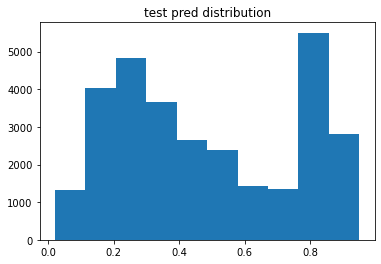

In [47]:
test_pred = cbr_best.predict_proba(test)[:, 1]

plt.hist(test_pred)
plt.title('test pred distribution')
plt.show()

In [48]:
test_submission = pd.DataFrame(sample_submission['id'])
test_submission['insomnia'] = test_pred
test_submission.head()

,id,insomnia
0,5,0.477405
1,6,0.487576
2,7,0.382093
3,10,0.512238
4,11,0.221517


In [49]:
# check shapes 

sample_submission.shape == test_submission.shape

True

In [50]:
sample_submission.head()

,id,insomnia
0,5,0.5
1,6,0.5
2,7,0.5
3,10,0.5
4,11,0.5


In [33]:
test_submission.to_csv('test_submission.csv')

### End